<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project4_storms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Storms
In this project, we will use Dedalus to solve the 2-layer quasi-geostrophic equations to model the development of atmospheric storm systems.

The two-layer quasi-geostrophic (QG) equations describe the motion of two vertically-stacked shallow layers of fluid in the limit where the Rossby number, $Ro=U/fL$ is small, where $U$ is a characteristic velocity scale, $L$ is a characteristic horizontal lengthscale, and $f$ is the Coriolis parameter. Here, we will use `1` to refer to quantitites in the upper layer and `2` to refer to quantities in the lower layer.

The fluid in the upper layer is lighter than the fluid in the lower layer (such that $\rho_1<\rho_2$). When the interface separating the upper and lower layers isn't flat, the varying thicknesses of the upper and lower layers implies that there are horizontal gradients in the hydrostatic pressure. When the Rossby number is small, $Ro\ll 1$, the flow will tend to be close to geostrophic balance a velocity difference between the upper and lower layer that balances the horizontal pressure gradients.

Student tasks are in [Section 1.5](#section1pt5), [Section 2.3](#section2pt3), and [Section 3.1](#section3pt1).

## 1. Two-layer quasi-geostrophic equations in a periodic box

In this section we will solve a non-dimensional version of the two-layer QG equations in Cartesian coordinates. Let $+x$ denote the eastwards direction and $+y$ denote the northwards direction. We start with a flow in geostrophic balance where the velocity is constant in each layer. Let $U \hat{\mathbf{x}}$ denote the velocity in the top layer and $-U \hat{\mathbf{x}}$ denote the velocity in the bottom layer. Geostrophic balance then implies that the interface has a constant, non-zero slope. We will invoke the so-called "beta-plane" approximation and make the Coriolis parameter a linear function of $y$. 

In this section we solve for the departures to the background state described above. We let $q_1$ and $q_2$ denote the perturbation QG potential vorticity and $\psi_1$ and $\psi_2$ denote the perturbation streamfunction. Although the background state is not periodic, we apply periodic boundary conditions in $x$ and $y$ to the perturbation quantities. This has the effect of maintaining the north/south potential vorticity gradient associated with the background state.

### 1.1 Governing equations

The script below solves the following equations:

$$ \partial_t(q_1) + U \partial_x(q_1) + \frac{2U}{R_{d1}^2}\partial_x(\psi_1)-\nu \nabla^2 q_1 = - J(\psi_1, q_1), $$

$$ \partial_t(q_2) - U \partial_x(q_2) - \frac{2U}{R_{d2}^2}\partial_x(\psi_2)-\nu \nabla^2 q_2 = - J(\psi_2, q_2), $$

where $R_{d1,2}=\sqrt{g'H_{1,2}}/f_0$ is the internal deformation radius in each layer, $g'=(\rho_2-\rho_1)/\rho_0$ is the reduced gravity, $\rho_0$ is a reference density, $J(a,b)=\partial_x(a)\partial_y(b) - \partial_y(a)\partial_x(b)$ is the Jacobian operator and $\nu$ is a viscosity which is added to keep the model stable.

In addition to the equations above, two other equations relate the perturbation potential vorticity and streamfunctions:

$$q_1=\nabla^2\psi_1 - \frac{\psi_1-\psi_2}{R_{d1}^2}, $$
$$q_2=\nabla^2\psi_2 + \frac{\psi_1-\psi_2}{R_{d2}^2}. $$

### 1.2 Tau method

The equations above are invariant to a constant added to $\psi_1-\psi_2$. Therefore, there are infinitely many solutions to the above equations and the coefficient matrix associated with the discretized equations will be singular. To avoid this, we can add an extra equation to the system to set this constant offset. Here, we do this by including the following equation:

$$ \int\int \psi_1 dxdy = 0 $$

which in effect ensures that the spatial mean of $\psi_1$ is zero. The problem now is that we have five equations for four unknowns. One fix is to include another unknown in our system. We will include a constant called $\tau_{\psi1}$ and we will add it to the equation relating the upper layer QG potential voricity and streamfunction which then becomes:

$$q_1=\nabla^2\psi_1 - \frac{\psi_1-\psi_2}{R_{d1}^2} + \tau_{\psi1}. $$

Since adding a constant to the potential vorticity and streamfunction doesn't have any impact on the dynamics of the system, adding $\tau_{\psi1}$ here won't cause any problems and we now have a fully constained set of equations.


### 1.3 Dedalus script

The script below solves the 2-layer QG equations given above with non-dimensional parameters. Note that the velocity gets faster as the simulation progresses. If you find that the code blows up (returns NaNs and a white screen), try reducing the timestep.

In [2]:
# # Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 64 # Number of gridpoints in x
Ny = 64 # Number of gridpoints in y
Lx = 100 # Domain size in x
Ly = 100 # Domain size in y
Rd1 = 3 # Deformation radius in layer 1
Rd2 = 3 # Deformation radius in layer 2
U = 1 # Background velocity in layer 1

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu = 0.2

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/U/100 # This is just an estimate based on the background velocity
stop_sim_time = 70

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Set the initial conditions
q1.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
q2.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U*dx(q1) + (2*U/Rd1**2.0)*dx(psi1) - nu*lap(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) - U*dx(q2) - (2*U/Rd2**2.0)*dx(psi2) - nu*lap(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")

problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK443)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])]; 
psi2_save = [np.copy(psi2['g'])]; 
q1_save = [np.copy(q1['g'])]; 
q2_save = [np.copy(q2['g'])]; 
t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)

2024-12-18 15:47:11,380 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.
2024-12-18 15:47:11,381 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".
2024-12-18 15:47:11,501 numexpr.utils 0/1 INFO :: NumExpr defaulting to 8 threads.
2024-12-18 15:47:12,139 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s
2024-12-18 15:47:12,170 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 9.0e+01/s
2024-12-18 15:47:12,209 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 9.5e+01/s
2024-12-18 15:47:12,250 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 9.6e+01/s
2024-12-18 15:47:12,290 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 9.7e+01/s
20

### 1.4 Visualization
The script below will make a movie showing the evolution of $\psi_2-\psi_1$, which is proportional to the displacement of the interior interface.

2024-12-18 15:51:57,889 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-18 15:51:57,891 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpmlo4gsvz/temp.m4v


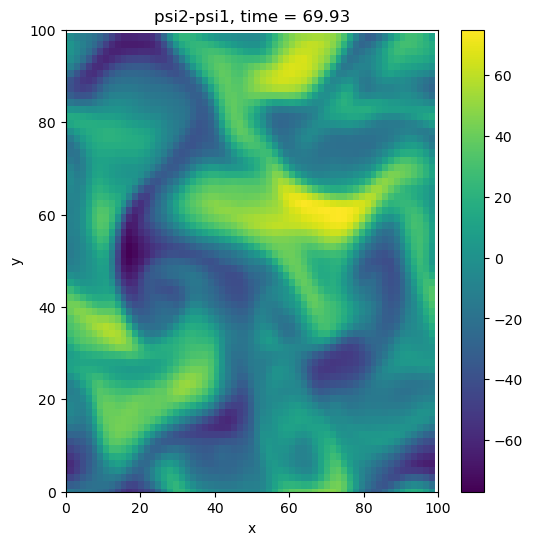

In [3]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  

# Define an animation function
def drawframe(n):
    plt.clf()
    streamfunction = plt.pcolor(X, Y, (psi2_save[n,:,:].T-psi1_save[n,:,:].T))
    # Specify the axis limits and labels
    plt.xlim(0, Lx)   
    plt.ylim(0, Ly)  
    plt.colorbar()      
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('psi2-psi1, time = {0:.2f}'.format(t_save[n]))
    return (streamfunction,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

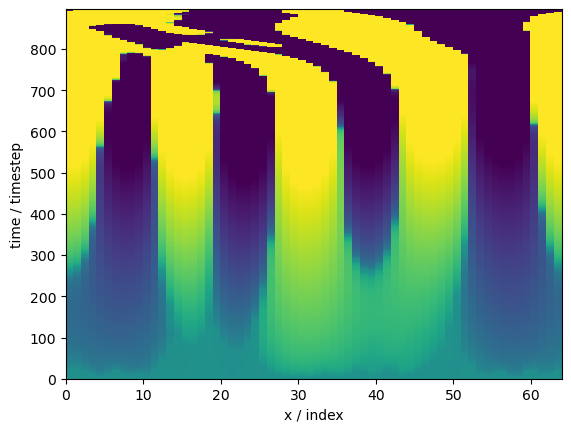

unstable_lambda = 25.0


Text(0, 0.5, 'smallest wavelength')

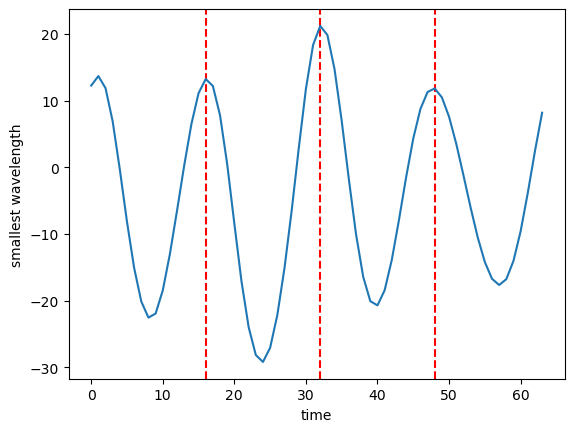

In [4]:
# obtaining lambda_numerical
import matplotlib.colors as colors
plt.pcolor(psi2_save[:,:,50]-psi1_save[:,:,50], norm=colors.SymLogNorm(linthresh=1e-3, linscale=1e-3, vmin=-1, vmax=1))
plt.xlabel('x / index')
plt.ylabel('time / timestep')
t_unstable = int(57/70 * 897)
plt.show()
min_wavelengths = []
y_loc = 60
for t in range(1, t_unstable):
    psi2_1 = psi2_save[t,:,y_loc]-psi1_save[t,:,y_loc]
    minimum_wavelength = 70
    peak_start_index = 0
    for i, psi in enumerate(psi2_1):
        if i > 1 and i < len(psi2_1)-1:
            if psi2_1[i+1] < psi and psi2_1[i-1] < psi:
                peak_end_index = i
                if peak_end_index - peak_start_index < minimum_wavelength:
                    #print(t, peak_end_index-peak_start_index)
                    minimum_wavelength = peak_end_index - peak_start_index
                peak_start_index = peak_end_index
                if t == t_unstable-1:
                    plt.axvline(x=peak_start_index, color='r', linestyle='--')

    min_wavelengths.append(minimum_wavelength * Lx / Nx)
#plt.plot(min_wavelengths)
#plt.show()
lambda_unstable = min_wavelengths[-1]
plt.plot(psi2_1)
print(f"unstable_lambda = {lambda_unstable}")
plt.xlabel('time')
plt.ylabel('smallest wavelength')

[ 0.01186751  5.85928487 -0.26080714 -5.97788861]
0.17066929187744662


<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2651/3242553990.py:19: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel(f"$(\psi_2 - \psi_1)^2$")


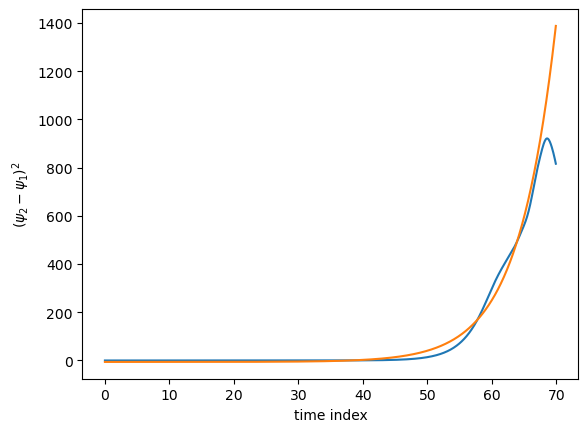

In [9]:
from scipy.optimize import curve_fit

square_thing = np.mean((psi2_save - psi1_save)**2, axis=(1,2))

def exponent(x, a, b, c, d):
    return a*np.exp(x/b+c)+d



t_save = np.asarray(t_save)

popt, pcov = curve_fit(exponent, t_save[:-50], square_thing[:-50], p0=[0.006, 6, 0.4, -6])

print(popt)

plt.plot(t_save, square_thing)
plt.plot(t_save, exponent(t_save, *popt))
plt.xlabel("time index")
plt.ylabel(f"$(\psi_2 - \psi_1)^2$")
sigma = 1/popt[1]
print(sigma)

### 1.5 Student investigation
<a id='section1pt5'></a>
In lectures, we found growing solutions of the form
 
$$ \psi_{1,2}=Re\left[\hat{\psi}_{1,2}e^{ikx+\sigma t}\right], $$

where

$$ \sigma = Uk \left(\frac{2/R_d^2-k^2}{2/R_d^2+k^2}\right)^{1/2}, $$

$$ \frac{d\sigma}{dk} = U \left(\frac{2/R_d^2-k^2}{2/R_d^2+k^2}\right)^{1/2} - \frac{4Uk^2}{R_d^2(2/R_d^2+k^2)^2} \left(\frac{2/R_d^2-k^2}{2/R_d^2+k^2}\right)^{-1/2} $$



is the exponential growth rate, $R_d=\sqrt{g'H}/f_0$ is the deformation radius in each layer, and $k$ is the wavenumber in the $x$ direction where $\lambda=2\pi/k$ is the wavelength.

In the box below, compare the result of the simulation with what you would expect based on the growth rate given above. Comment on the possible reasons for any differences. Discuss the behaviour of the flow in the simulation at later times and comment on the relevance to storms in the atmosphere.

In [7]:
l_range = np.linspace(0, 60, 100)
k_range = 2*np.pi/l_range
braket_expression = np.sqrt((2/(Rd1**2) - k_range**2)/(2/(Rd2**2) + k_range**2))
dk_sigma = U * (braket_expression - ((4*k_range**2)/((2/(Rd2**2) + k_range**2)**2*Rd2**2))/braket_expression)

k_val = k_range[34]
sigma2 = U * k_val * (braket_expression[34])
l_val = 2*np.pi/k_val

print(f"\n sigma theoretical = {sigma2}, numerical = {sigma}, lambda theoretical = {l_val}, lambda numerical = {lambda_unstable}\n")



 sigma theoretical = 0.19525514478992362, numerical = 0.17066929187744662, lambda theoretical = 20.606060606060606, lambda numerical = 25.0



/tmp/ipykernel_2651/1879070379.py:2: RuntimeWarning: divide by zero encountered in divide
  k_range = 2*np.pi/l_range
/tmp/ipykernel_2651/1879070379.py:3: RuntimeWarning: invalid value encountered in divide
  braket_expression = np.sqrt((2/(Rd1**2) - k_range**2)/(2/(Rd2**2) + k_range**2))
/tmp/ipykernel_2651/1879070379.py:3: RuntimeWarning: invalid value encountered in sqrt
  braket_expression = np.sqrt((2/(Rd1**2) - k_range**2)/(2/(Rd2**2) + k_range**2))
/tmp/ipykernel_2651/1879070379.py:4: RuntimeWarning: invalid value encountered in divide
  dk_sigma = U * (braket_expression - ((4*k_range**2)/((2/(Rd2**2) + k_range**2)**2*Rd2**2))/braket_expression)


<span style="color:#ff3300">
INSERT COMMENTS HERE

Plots above used to determine the numerical wavelength, and code above used to determine the numerical sigma

As can be seen by the output of the above code, the numerically derived value for growth rate (sigma) is 0.171, which is slightly lower than the theoretical maximum (0.195). This is to be expected as the noise generated to intiate the simulation will produce a bandwidth of wavelengths with slightly different but similar wavenumbers.
These wavelengths will intefere with each other preventing the theoretical growth rates from being reached.

This theoretical growth rate leads to a theoretical optimal wavelength of 20.6
The final wavelength seen before the system becomes chaotic is 25.
When the simulation is initated a single standing wave oscillation is visible. This quickly degenerates to a set of two, three and then four peaks (as visible in the first plot). Hence a wavelength of 25 (One quarter of the overall width (100)) is seen. When this begins to degenerate into 5 peaks, the system will contain significant quantities of waves with wavelength 20, which is almost exactly the maximum growth rate, leading to a rapid descent into a chaotic system - wavelengths of order 20 are only seen very briefly.

At long timescales (i.e. when t > 57) there is no patterns remaining in the system and it has become fully chaotic. This will represent complex storm systems in the atmosphere that can form from the simple pertubations used to initate the simulation, coinciding with the breakdown of the regular pseudo-steady state visible from t=30 to t=55.



## 2. Jet stream and the dimensional QG equations

The configuration in the previous section illustrates baroclinic instability, but the setup is quite idealized. In particular, we assumed that the Coriolis parameter and the initial velocity were constant. In the atmosphere there is are strong winds at the top of the troposphere in a band called the jet stream. The jet stream is several hundred kilometers wide with wind speeds that can exceed 100 miles per hour (roughly 50 m/s). A variable Coriolis parameter is important for constraining the jet dynamics. If we use $f=f_0+\beta y$, then the equations for $q_1$ and $q_2$ become:

$$ \partial_t(q_1) + U_1 \partial_x(q_1) + \partial_x(\psi_1)\left(\beta + \frac{U_1-U_2}{R_{d1}^2}\right)+\nu_4 \nabla^4 q_1 = - J(\psi_1, q_1), $$

$$ \partial_t(q_2) + U_2 \partial_x(q_2) + \partial_x(\psi_2)\left(\beta + \frac{U_2-U_1}{R_{d2}^2}\right)+\nu_4 \nabla^4 q_2 = - J(\psi_2, q_2). $$

Here, we have also switched from a viscous term to a 'hyperviscous' term, where $-\nabla^2 q_{1,2}$ has been replaced by $\nabla^4 q_{1,2}$ where $\nabla^4=(\nabla^2)^2=(\partial^2_x+\partial^2_y)^2$. Using a hyperviscosity is useful because it acts to preferentially damp small scale motions (with large horizontal wavenumbers), while having less influence on the larger scale motions (with small horizontal wavenumbers). It is useful in this case since we would like the jet not to be strongly influenced by viscosity.

We can simulate baroclinic instability on the jet stream by localizing the north/south gradient in the QG potential voriticty in the center of our computational domain. However, since our boundary conditions are periodic, we need the potential vorticity that we solve for to be equal at the northern and southern boundaries. We can accomplish this with the following trick. For our initial condition, let the total potential vorticity in layer 1 be:

$$ q_1 = Q_1 tanh\left(\frac{y-Ly/2}{w}\right) $$

where $Ly$ is the domain size, $Q_1$ is a constant dimensional amplitude and $w$ is the jet width. Clearly $q_1$ isn't periodic in the y-direction. Instead, we can impose a uniform background potential vorticity gradient (as we did in Section 1 above) and solve for the departure from this background gradient. We can then set the amplitude of the background gradient to make the <em>departure</em> from the background gradient periodic. Specifically, the departure from the background potential vorticity gradient will be:

$$ q_1 = Q_1 (tanh\left(\frac{y-Ly/2}{w}\right) - \frac{y-Ly/2}{Ly/2}) $$

which is periodic in $y$ (check for yourself if you aren't sure), and the background potential voricity gradient will be $2Q_1/Ly$ which then ensures that the total PV is the tanh function defined above. 

### 2.1 Dedalus script

The script below sets up and solves the 2-layer QG equations in dimensional units (kilometers for x, y and seconds for time). The size of the box is 30,000 km in the x-direction and 10,000 km in the y-direction. This roughly corresponds to the Northern Hemisphere, although it is important to note that the analogy is only approximate since we are still solvin the equations in a Cartesian geometry and not a sphere.

Run the script below and comment on the results and the behavior of the jet stream in the text box below the script. You can also try changing some of the parameters at the top of the script to see how the result change.

Note that the script will likely take a few minutes to run.  Coordinate with the other members of your group so that you can each run a different case.

In [4]:
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient 
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])]; 
psi2_save = [np.copy(psi2['g'])]; 
q1_save = [np.copy(q1['g'])]; 
q2_save = [np.copy(q2['g'])]; 

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)


2024-11-28 14:16:21,361 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 4.6e+01/s
2024-11-28 14:16:21,436 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 5.2e+01/s
2024-11-28 14:16:21,528 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s
2024-11-28 14:16:21,619 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 5.4e+01/s
2024-11-28 14:16:21,709 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 0s, Remaining: 1s, Rate: 5.4e+01/s
2024-11-28 14:16:21,797 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+01/s
2024-11-28 14:16:21,886 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 5.5e+01/s
2024-11-28 14:16:21,974 subsystems 0/1 INFO :: Building subproblem matri

### 2.2 Visualization

The script below will visualize the results and create a movie showing the upper layer wind speed (the magnitude of the velocity vector (u1, v1)).

2024-11-28 14:18:11,672 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-11-28 14:18:11,673 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpbq_mgwej/temp.m4v


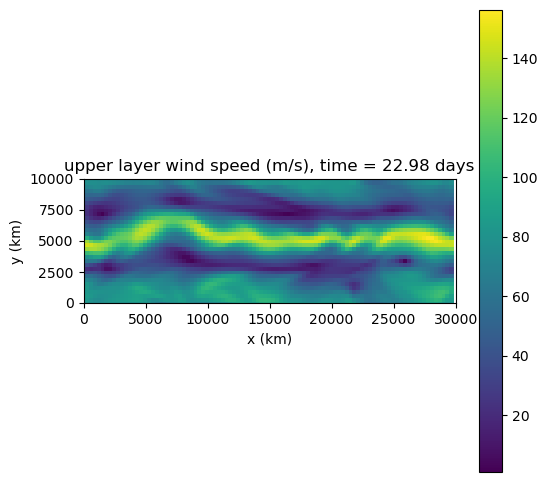

In [5]:
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)   
    plt.ylim(0, Ly)  
    plt.colorbar()      
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Describe the results in the box below. To what extent are the results qualitatively different from what you saw using the previous script? Comment on the interaction between the jet and the storms. Which features in the simulation do you think occur in the atmosphere? Do you see any features in the simulation that you think are unrealistic? If so, explain why you think those features are unrealistic. 

<span style="color:#ff3300">
ADD COMMENTS HERE.

Linear jetstream meanders and then become chaotic. Counter-clockwise cyclonic disturbances form that represent the formation of storms within the north atlantic. The system stabilises into a pseudo steady state, where a prevailing eastward jet is visible that sheds eddies in both the north and south directions. The velocity is fastest within the jet, with the storms that peel off having reduced speed and travelling westwards.

The results are different from the previous script in that the final state shows an overall eastward jet, created by the temperature and windspeed gradients.

Storms push the jet from side to side, creating a wiggle in the jet and preventing it from being completely linear.

As the quadratic viscosity term is replaced by a quartic hyperviscocity term, small eddies are ignored and only large scale motions will affect the system.

Both the jet and the eddies occur in the atmosphere, in the form of the gulf-stream and storm systems. However, the quantity and size of storms is likely larger than expected as the lack of small eddies prevents the large eddies from fracturing into smaller chaotic weather systems. Furthermore, the addition of damping/temperature gradient in section 3 will address this problem. The storms also appear to move westwards, which does not happen in the atmosphere. This is probably caused by the boundary conditions requiring conservation of momentum, and this could be improved by modelling it in a polar coordinate system rather than cartesian as well as adding the southern hemisphere.

The system is not ideal as it uses a linear approximation for the coriolis parameter. Changing this would improve the accuracy of the simulation. Additionally, the cyclic boundary conditions requires idealised tanh curves a slight computational limitation that further increases the inaccuracy in the system.

# 3. Forced QG flow

In the atmosphere, differential heating between the equator and poles maintains a north/south temperature gradient. This temperature gradient is represented by the north/south gradient in layer heights and potential vorticity in the 2-layer QG model. We can represent differential heating and cooling in the 2-layer QG model by adding terms that 'relax' the potential vorticity back to a prescribed field.

### 3.1 Student investigation
<a id='section3pt1'></a>

In the code box below, copy the code from Part 2 and modify it to include the following terms:
$$ \frac{\partial q_1}{\partial t} + \ldots = \ldots - \frac{1}{\tau}\left(q_1 - q_1(t=0)\right) $$

$$ \frac{\partial q_2}{\partial t} + \ldots = \ldots - \frac{1}{\tau}\left(q_2 - q_2(t=0)\right) $$ 

where $q_i(t=0)$ are the initial conditions (q1_ic and q2_ic in the script) and $\tau$ is a timescale which you should specify. A timescale of $\tau=36$ hours should be a good starting point. In the absence of any other terms, this additional forcing term will cause $q_1$ and $q_2$ to 'relax' exponentially back to the initial conditions with an e-folding timescale equal to $\tau$. 

Climate change is expected to reduce the equator to pole temperature contrast as the high latitudes warm faster than the rest of the planet. This will have impacts on the intensity and dynamics of storms. Experiment with this by changing the pole to equator gradient in the prescribed initial potential vorticity. Specify which dimensional parameter you chose to vary and discuss how it relates to the north/south temperature gradient. What happens to the jet stream and the storms as you reduce the potential vorticity gradient?

In [10]:
# SIMULATION
# Copy and paste the code from section 2.1 here and modify to add the relaxation terms. 
# Also, paste the code to visualize the results (or create a new code box below)
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 5/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200
tau = 36 * (60*60)# Relaxation timescale in seconds
#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient 
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1) - (q1-q1_ic)/tau")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2) - (q2-q2_ic)/tau")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])]; 
psi2_save = [np.copy(psi2['g'])]; 
q1_save = [np.copy(q1['g'])]; 
q2_save = [np.copy(q2['g'])]; 

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)


2024-12-18 17:08:09,787 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 7.7e+01/s
2024-12-18 17:08:09,838 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 7.8e+01/s
2024-12-18 17:08:09,901 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 0s, Rate: 7.9e+01/s
2024-12-18 17:08:09,963 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 0s, Rate: 7.9e+01/s
2024-12-18 17:08:10,026 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 0s, Remaining: 0s, Rate: 8.0e+01/s
2024-12-18 17:08:10,087 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 0s, Remaining: 0s, Rate: 8.0e+01/s
2024-12-18 17:08:10,149 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 8.0e+01/s
2024-12-18 17:08:10,212 subsystems 0/1 INFO :: Building subproblem matri

2024-12-18 17:08:51,887 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-18 17:08:51,888 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp_633fj1p/temp.m4v


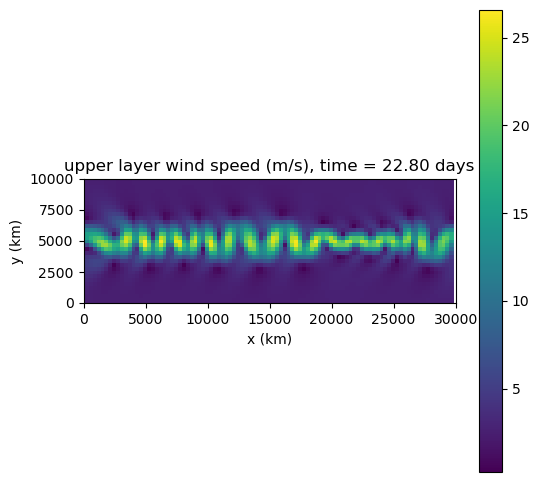

In [11]:
# PLOTTER
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)   
    plt.ylim(0, Ly)  
    plt.colorbar()      
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

In [12]:
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


<span style="color:red">
The parameter selected to be changed is the background velocity, U1. This is chosen as it a greater north/south gradient would result in a higher north south velocity due to the below relation between velocity and temperature gradient:

$ \frac{\partial u}{\partial z} = - \frac{R}{f} \frac{\partial T}{\partial y}$

Increasing U1 decreases the stability of the system as can be seen in the plots below. This is expected as the greater north/south temperature gradient would result in more energy being present in the system.

As the potenital vorticity gradient is decreased, the system becomes more stable and the meanders seen in the jet rarely produce eddies. Additionally, the jet velocity decreases significantly, as can be seen by the colourbars on the below plots. Global warming will result in a smaller temperature gradient and hence a reduced jet stream strength. This would result in a lack of warm air being transported to Europe and a dramatic change in conditions, particularly an increase in colder winter conditions. 

When the gradient is decreased the eddies become more localised along the mid latitudes.

A damping timescale of 36 hours is used throughout as it maintains a stable, non-chaotic system for all the different gradients. This damping prevents the production of excessive number of eddies, as was discussed earlier.

PLOTS

No damping, default gradient:

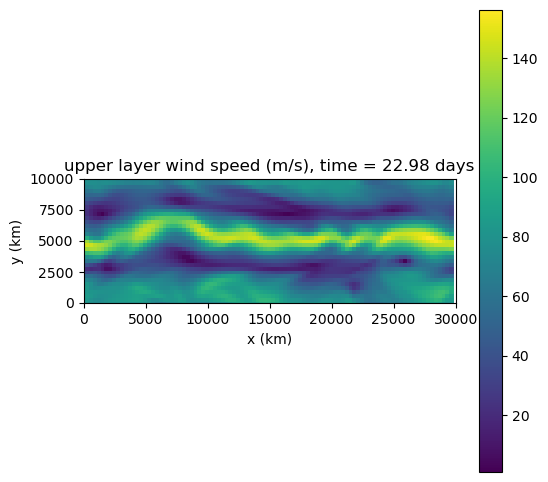

Damping (36hrs), default gradient (U1 = 10m/s):

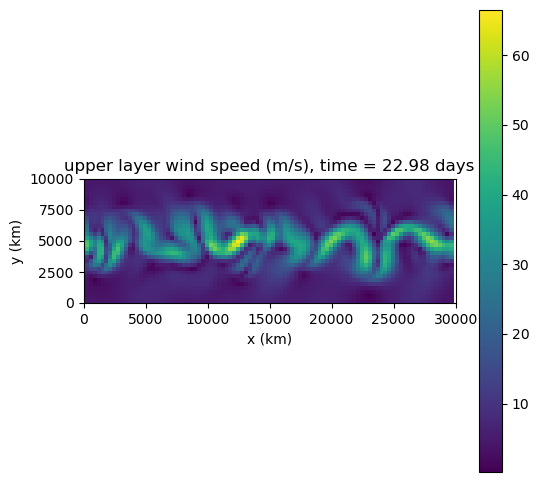

Damping (36hrs), double gradient (U1 = 20m/s):

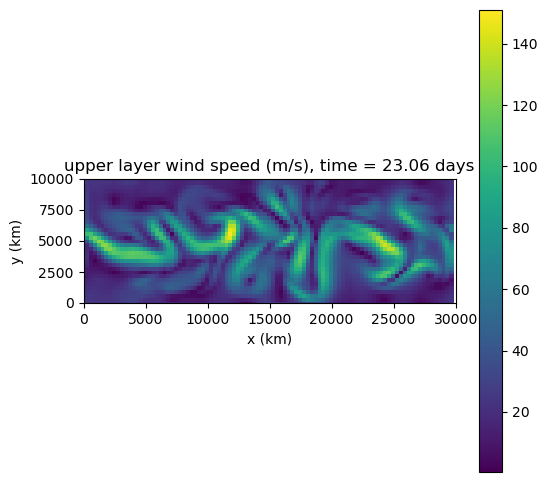

Damping (36hrs), half gradient (U1 = 5m/s):

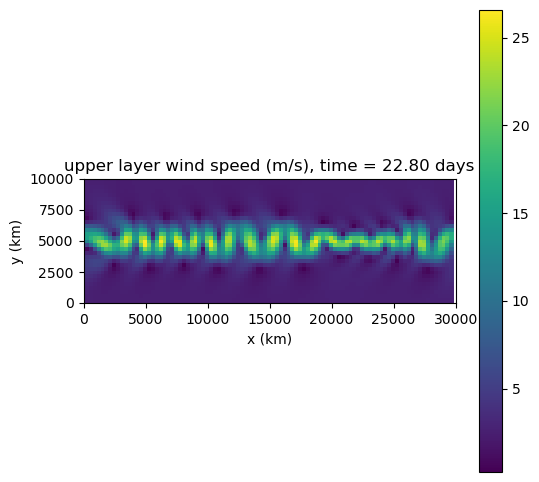
